In [11]:
from utils import *
from args import *
from model import *

class Args:
    def __init__(self):
        self.dataset = "phone-email"
        self.ratio = 0.2
        self.use_attr = False
        self.distance = "rwr"
        self.device = "cpu"
        self.use_gcn = False
        self.num_gcn_layers = 1
        self.use_parrot = True
        self.use_cross_rwr = False

def load(args):
    # check compatibility between dataset and use_attr
    if args.dataset == 'noisy-cora1-cora2':
        assert args.use_attr is True, 'noisy-cora1-cora2 requires using node attributes'
    elif args.dataset == 'foursquare-twitter' or args.dataset == 'phone-email':
        assert args.use_attr is False, 'foursquare-twitter does not have node attributes'
    
    # load data and build networkx graphs
    print("Loading data...")
    edge_index1, edge_index2, x1, x2, anchor_links, test_pairs = load_data(f"datasets/{args.dataset}", args.ratio, args.use_attr)
    G1, G2 = build_nx_graph(edge_index1, x1), build_nx_graph(edge_index2, x2)
    num_anchor_links = anchor_links.shape[0]
    
    # compute distance metric scores (e.g. random walk with restart (rwr))
    dists_score1, dists_score2 = get_distance_matrix(G1, G2, anchor_links, args.dataset, args.ratio, args.distance)
    if args.use_parrot:
        parrot = np.load(f'datasets/rwr_parrot/rwr_cost_{args.dataset}.npz')
        dists_score1, dists_score2 = parrot['rwr1'], parrot['rwr2']
    
    # device setting
    assert torch.cuda.is_available() or args.device == 'cpu', 'CUDA is not available'
    device = torch.device(args.device)
    
    # build PyG Data objects
    G1_data = build_tg_graph(G1.number_of_nodes(), edge_index1, x1, anchor_links[:, 0], dists_score1).to(device)
    G2_data = build_tg_graph(G2.number_of_nodes(), edge_index2, x2, anchor_links[:, 1], dists_score2).to(device)
    if args.use_gcn:
        gcn_output = np.load(f'gcn_out/{args.dataset}_gcn_results_{args.num_gcn_layers}_layers.npz')
        G1_data.x = torch.tensor(gcn_output['x1'], dtype=torch.float).to(device)
        G2_data.x = torch.tensor(gcn_output['x2'], dtype=torch.float).to(device)

    r1, r2 = G1_data.dists, G2_data.dists
    x1, x2 = G1_data.x, G2_data.x
    r1, r2 = F.normalize(r1, p=2, dim=1), F.normalize(r2, p=2, dim=1)
    x1, x2 = F.normalize(x1, p=2, dim=1), F.normalize(x2, p=2, dim=1)
    
    return r1, r2, x1, x2

In [12]:
import matplotlib.pyplot as plt

def visualize(dist_rwr, dist_x, dist_combined):
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))
    axs[0].imshow(dist_rwr, cmap='gray')
    axs[1].imshow(dist_x, cmap='gray')
    axs[2].imshow(dist_combined, cmap='gray')

In [101]:
def load_parrot_out(args):
    s = torch.load(f"outputs/parrot/parrot_{args.dataset}_similarity.pt")
    # dist = torch.sum(s, axis=1, keepdim=True) - s
    dist = s
    return dist

def load_pgna_out(args):
    data = np.load(f'outputs/pgna/pgna_{args.dataset}_embeddings.npz')
    emb1, emb2 = torch.from_numpy(data['out1'].astype(np.float32)), torch.from_numpy(data['out2'].astype(np.float32))
    emb1 = emb1 / torch.linalg.norm(emb1, dim=1, keepdim=True)
    emb2 = emb2 / torch.linalg.norm(emb2, dim=1, keepdim=True)
    return emb1 @ emb2.T

In [13]:
args = Args()
r1, r2, x1, x2 = load(args)

Loading data...
Loading rwr scores from datasets/rwr/rwr_emb_phone-email_0.2.npz... Done


In [14]:
alpha = 0.1
dist_r_exp = torch.exp(-(r1 @ r2.T))
dist_x_exp = torch.exp(-(x1 @ x2.T))
dist_exp = alpha * dist_r_exp + (1 - alpha) + dist_x_exp

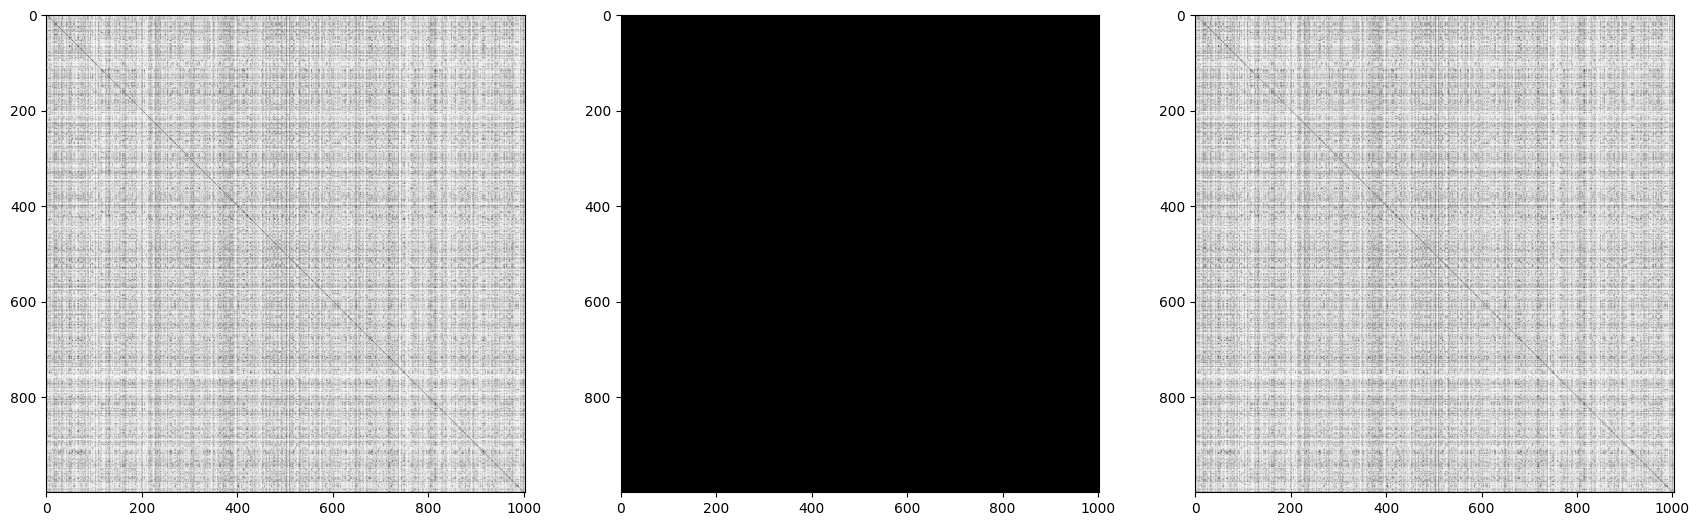

In [15]:
visualize(dist_r_exp, dist_x_exp, dist_exp)

In [102]:
dist_parrot = load_parrot_out(args)
dist_parrot

tensor([[1.0000e-03, 9.5082e-33, 9.5082e-33,  ..., 9.5082e-33, 9.5082e-33,
         9.5082e-33],
        [9.5082e-33, 1.0000e-03, 9.5082e-33,  ..., 9.5082e-33, 9.5082e-33,
         9.5082e-33],
        [9.5082e-33, 9.5082e-33, 1.5825e-04,  ..., 2.2155e-07, 2.2155e-07,
         2.2155e-07],
        ...,
        [9.5082e-33, 9.5082e-33, 9.5082e-33,  ..., 9.5082e-33, 9.5082e-33,
         9.5082e-33],
        [9.5082e-33, 9.5082e-33, 5.4834e-06,  ..., 1.2339e-08, 1.2339e-08,
         1.2339e-08],
        [9.5082e-33, 9.5082e-33, 1.3539e-22,  ..., 1.5930e-15, 1.5930e-15,
         1.5930e-15]], dtype=torch.float64)

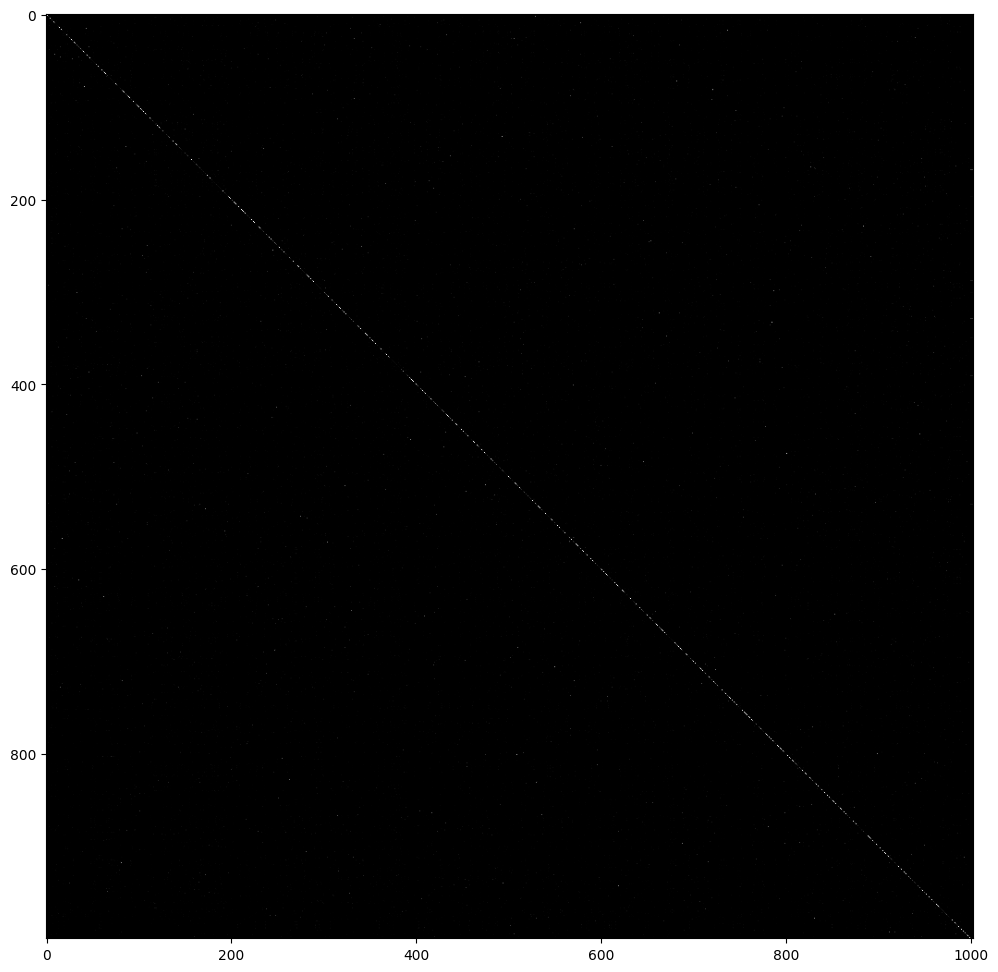

In [111]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.imshow(dist_parrot.numpy(), cmap="gray")

In [93]:
(torch.argsort(1 - dist_parrot, dim=1)[:, 0] == torch.arange(1000)).sum()

tensor(461)

In [103]:
dist_pgna = load_pgna_out(args)
print(dist_pgna)

tensor([[ 0.9939,  0.1332, -0.1034,  ..., -0.1760, -0.1760, -0.1760],
        [ 0.1213,  0.9946, -0.1393,  ..., -0.1890, -0.1890, -0.1890],
        [-0.0166, -0.0515,  0.4612,  ...,  0.1442,  0.1442,  0.1442],
        ...,
        [ 0.1057, -0.0569, -0.0574,  ..., -0.0491, -0.0491, -0.0491],
        [-0.0256, -0.0543,  0.4079,  ...,  0.0931,  0.0931,  0.0931],
        [ 0.0594,  0.0545, -0.7086,  ..., -0.6675, -0.6675, -0.6675]])


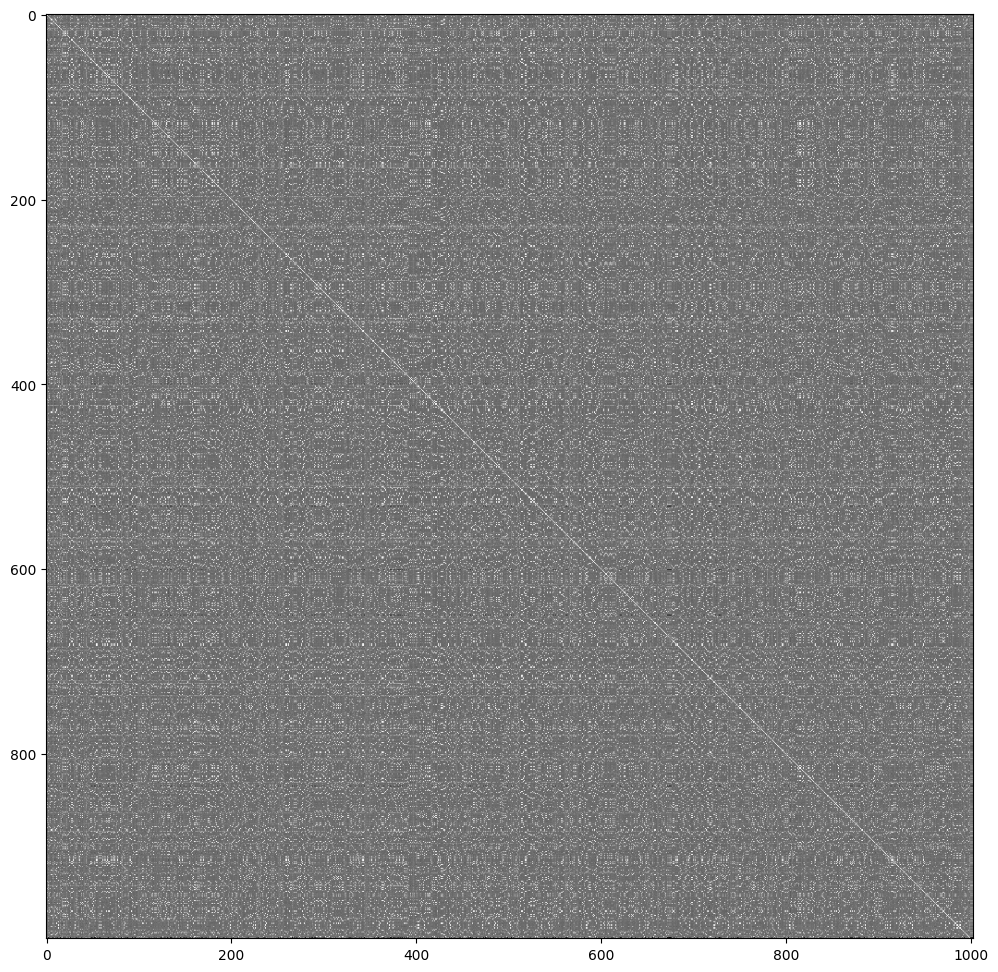

In [109]:
fig, ax = plt.subplots(figsize=(20, 12 ))
ax.imshow(dist_pgna.numpy(), cmap="gray")

In [97]:
(torch.argsort(dist_pgna, dim=1)[:, 0] == torch.arange(1000)).sum()

tensor(222)

In [100]:
dist_pgna.sum(1).min(), dist_pgna.sum(1).max()

(tensor(867.0251), tensor(1071.4395))

In [95]:
dist_pgna.shape

torch.Size([1000, 1003])